In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from packaging import version
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.layers.core import Dropout
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.cluster import KMeans
from keras import regularizers

Using TensorFlow backend.


In [2]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [3]:
#flow from directory

train_datagen = ImageDataGenerator(
      rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        'fake_data2',
        # All images will be resized to 28x28
        target_size=(28, 28),
        batch_size=12000,
        class_mode='sparse',
        color_mode = 'grayscale',
        classes = ['type0*','typeIA*','typeIB*','typeIIA*','typeIIB*','typeIII*'])

imgs, labels = next(train_generator)

Found 12000 images belonging to 6 classes.


In [14]:
instances = []
directory =   os.fsencode('fake_data1/type1')
directory2 =  os.fsencode('fake_data1/type2')
directory3 =  os.fsencode('fake_data1/type3')
directory4 =  os.fsencode('fake_data1/type4')
directory5 =  os.fsencode('fake_data1/type5')
# Load in the images
for filepath in os.listdir(directory):
    path= 'fake_data1/type1/{0}'.format(os.fsdecode(filepath))
    instances.append(path)

for filepath in os.listdir(directory2):
    path= 'fake_data1/type2/{0}'.format(os.fsdecode(filepath))
    instances.append(path)
    
for filepath in os.listdir(directory3):
    path= 'fake_data1/type3/{0}'.format(os.fsdecode(filepath))
    instances.append(path)

for filepath in os.listdir(directory4):
    path= 'fake_data1/type4/{0}'.format(os.fsdecode(filepath))
    instances.append(path)

for filepath in os.listdir(directory5):
    path= 'fake_data1/type5/{0}'.format(os.fsdecode(filepath))
    instances.append(path)

y = np.array([np.array(cv2.resize(cv2.imread(fname,0), dsize=(28,28), interpolation=cv2.INTER_CUBIC)) for fname in instances if fname not in 'fake_data1/type4/.DS_Store'])


In [15]:
y = y.reshape(y.shape[0], 28, 28, 1)
y = y/255

In [4]:
# Data & model configuration
img_width, img_height = 28,28
batch_size = 128
no_epochs = 200
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1

# Reshape data
#imgs = imgs.reshape(imgs.shape[0], 28, 28, num_channels)
input_shape = (img_height, img_width, num_channels)

In [5]:
# # =================
# # Encoder
# # =================

# Definition
i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.01))(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.01))(cx)
cx      = BatchNormalization()(cx)
cx      = Dropout(0.25)(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu',kernel_regularizer=regularizers.l2(0.01))(x)
sigma   = Dense(latent_dim, name='latent_sigma',kernel_regularizer=regularizers.l2(0.01))(x)

# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)

# Define sampling with reparameterization trick
def sample_z(args):
    mu, sigma = args
    batch     = K.shape(mu)[0]
    dim       = K.int_shape(mu)[1]
    eps       = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps

# Use reparameterization trick to ....??
z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

In [6]:
# Instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 8)    80          encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 14, 14, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 16)     1168        batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [7]:
# =================
# Decoder
# =================

# Definition
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu',kernel_regularizer=regularizers.l2(0.01))(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
cx    = BatchNormalization()(cx)
cx    = Dropout(0.25)(cx)
cx    = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu',kernel_regularizer=regularizers.l2(0.01))(cx)
cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output',kernel_regularizer=regularizers.l2(0.01))(cx)

# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               2352      
_________________________________________________________________
batch_normalization_4 (Batch (None, 784)               3136      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 16)        2320      
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 16)        0   

In [8]:
# =================
# VAE as a whole
# =================

# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae         = Model(i, vae_outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 17208     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         9137      
Total params: 26,345
Trainable params: 24,641
Non-trainable params: 1,704
_________________________________________________________________


In [9]:
# Define loss
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

In [10]:
# Compile VAE
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

In [11]:
# Define the Keras TensorBoard callback.
%reload_ext tensorboard
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [16]:
# Train autoencoder
vae.fit(z, z, epochs = 200, batch_size = batch_size, validation_split = validation_split,shuffle=True, callbacks=[tensorboard_callback])

Train on 900 samples, validate on 225 samples
Epoch 1/200
900/900 [==============================] - 11s 12ms/step - loss: 635.6341 - val_loss: 539.4044
Epoch 2/200
900/900 [==============================] - 1s 1ms/step - loss: 595.2871 - val_loss: 532.1998
Epoch 3/200
900/900 [==============================] - 1s 1ms/step - loss: 563.6910 - val_loss: 522.8736
Epoch 4/200
900/900 [==============================] - 1s 1ms/step - loss: 545.2275 - val_loss: 510.9786
Epoch 5/200
900/900 [==============================] - 1s 2ms/step - loss: 525.9063 - val_loss: 498.1086
Epoch 6/200
900/900 [==============================] - 2s 2ms/step - loss: 504.9224 - val_loss: 482.6501
Epoch 7/200
900/900 [==============================] - 2s 2ms/step - loss: 480.7499 - val_loss: 461.7520
Epoch 8/200
900/900 [==============================] - 1s 2ms/step - loss: 454.6258 - val_loss: 437.2884
Epoch 9/200
900/900 [==============================] - 2s 2ms/step - loss: 423.8361 - val_loss: 408.0458
Epoch 1

Epoch 79/200
900/900 [==============================] - 1s 2ms/step - loss: 62.6260 - val_loss: 63.8734
Epoch 80/200
900/900 [==============================] - 1s 2ms/step - loss: 61.9710 - val_loss: 63.6458
Epoch 81/200
900/900 [==============================] - 1s 2ms/step - loss: 62.1603 - val_loss: 62.8657
Epoch 82/200
900/900 [==============================] - 1s 2ms/step - loss: 62.7895 - val_loss: 63.1817
Epoch 83/200
900/900 [==============================] - 1s 2ms/step - loss: 62.8695 - val_loss: 63.4824
Epoch 84/200
900/900 [==============================] - 1s 2ms/step - loss: 63.0172 - val_loss: 62.5067
Epoch 85/200
900/900 [==============================] - 2s 2ms/step - loss: 62.6822 - val_loss: 62.3398
Epoch 86/200
900/900 [==============================] - 1s 2ms/step - loss: 62.2631 - val_loss: 61.8005
Epoch 87/200
900/900 [==============================] - 1s 2ms/step - loss: 61.5149 - val_loss: 61.6606
Epoch 88/200
900/900 [==============================] - 1s 2ms/s

In [160]:
%tensorboard --logdir logs


Reusing TensorBoard on port 6007 (pid 23109), started 22:23:29 ago. (Use '!kill 23109' to kill it.)

In [173]:
latent_space = encoder.predict(imgs)

In [174]:
latent_space = np.array(latent_space)

In [175]:
x12, y12 = zip(*latent_space[0])

In [176]:
x12= np.array(x12)

In [177]:
y12 = np.array(y12)

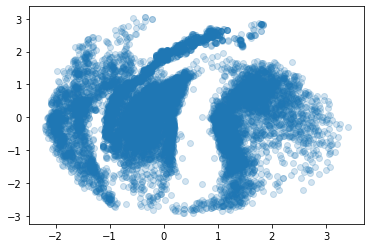

In [178]:
plt.scatter(x12,y12, alpha=0.2)

In [188]:
decoded_img = vae.predict(z)

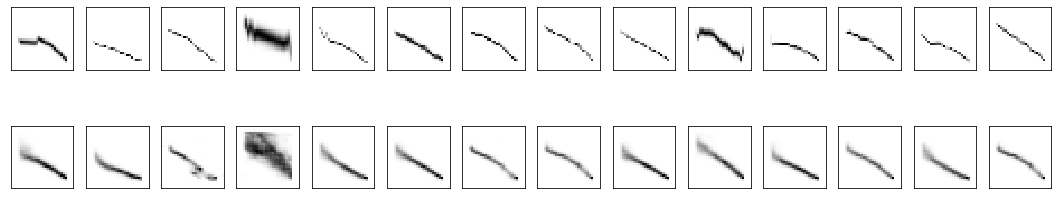

In [189]:
#display original and reconstructed images
n = 15
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(z[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_img[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [181]:
def viz_decoded(encoder, decoder, data):
    num_samples = 15
    figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
    grid_x = np.linspace(-4, 4, num_samples)
    grid_y = np.linspace(-4, 4, num_samples)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_width, img_height, num_channels)
            figure[i * img_width: (i + 1) * img_width,
                      j * img_height: (j + 1) * img_height] = digit
    plt.figure(figsize=(10, 10))
    start_range = img_width // 2
    end_range = num_samples * img_width + start_range + 1
    pixel_range = np.arange(start_range, end_range, img_width)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
    # So reshape if necessary
    fig_shape = np.shape(figure)
    if fig_shape[2] == 1:
        figure = figure.reshape((fig_shape[0], fig_shape[1]))
    # Show image
    plt.imshow(figure)
    plt.show()

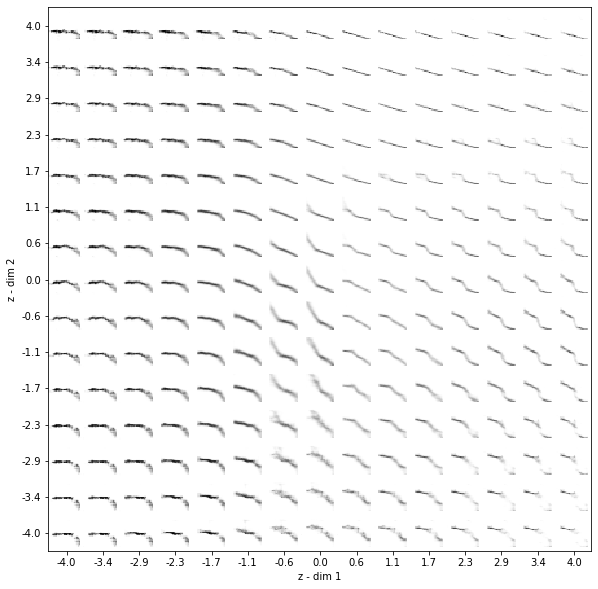

In [182]:
data = (imgs, imgs)
viz_decoded(encoder, decoder, data)

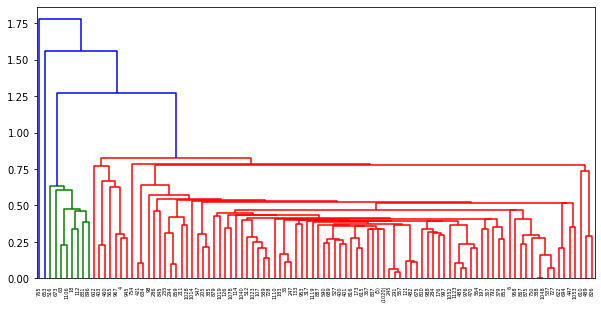

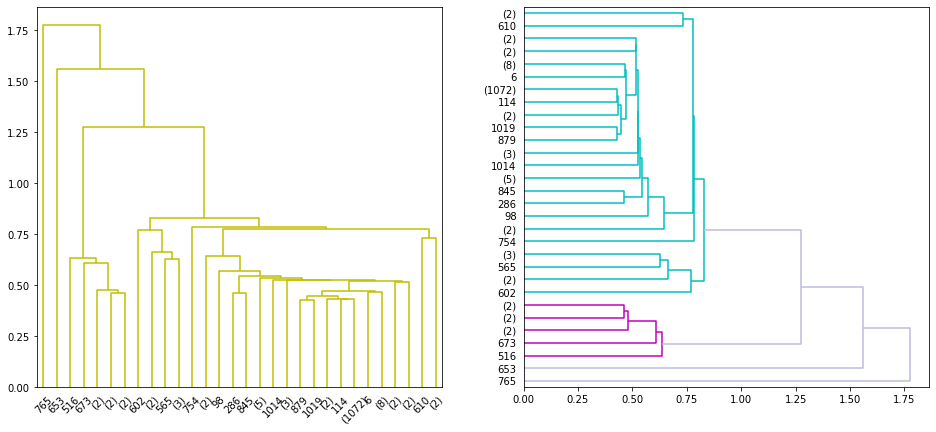

In [19]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(latent_space1[0], 'single')
plt.figure(1,figsize=(10,5))
dn = hierarchy.dendrogram(Z, truncate_mode='level')
hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='y',
                            orientation='top', truncate_mode='lastp', color_threshold=0)
dn2 = hierarchy.dendrogram(Z, ax=axes[1],
                           above_threshold_color='#bcbddc',
                            orientation='right', truncate_mode='lastp')
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()


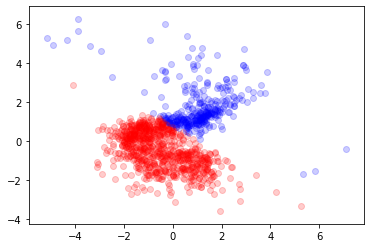

In [107]:
#latent space showing clusters - change n_clusters up to 7
n_clusters = 2
#Runs in parallel 4 CPUs
kmeans = KMeans(n_clusters=n_clusters, n_init=20, n_jobs=4)
#Train K-Means.
y_pred_kmeans = kmeans.fit_predict(latent_space1[0])

plt.figure()
for i in range(0,1125):
    if y_pred_kmeans[i]==0:
        plt.scatter(latent_space1[0,i,0],latent_space1[0,i,1], alpha=0.2, c='blue')
    elif y_pred_kmeans[i]==1:
        plt.scatter(latent_space1[0,i,0],latent_space1[0,i,1], alpha=0.2, c='red')
    elif y_pred_kmeans[i]==2:
        plt.scatter(latent_space1[0,i,0],latent_space1[0,i,1], alpha=0.2, c='green')
    elif y_pred_kmeans[i]==3:
        plt.scatter(latent_space[0,i,0],latent_space[0,i,1], alpha=0.2, c='yellow')
    elif y_pred_kmeans[i]==4:
        plt.scatter(latent_space[0,i,0],latent_space[0,i,1], alpha=0.2, c='purple')
    elif y_pred_kmeans[i]==5:
        plt.scatter(latent_space[0,i,0],latent_space[0,i,1], alpha=0.2, c='orange')
    elif y_pred_kmeans[i]==6:
        plt.scatter(latent_space[0,i,0],latent_space[0,i,1], alpha=0.2, c='pink')

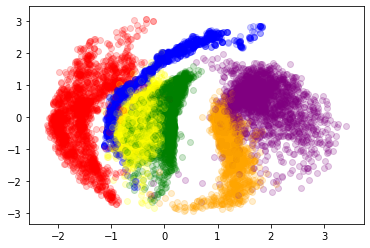

In [172]:
plt.figure()
for i in range(0,12000):
    if labels[i]==0.:
        plt.scatter(latent_space[0,i,0],latent_space[0,i,1], alpha=0.2, c='blue')
    elif labels[i]==1.:
        plt.scatter(latent_space[0,i,0],latent_space[0,i,1], alpha=0.2, c='red')
    elif labels[i]==2.:
        plt.scatter(latent_space[0,i,0],latent_space[0,i,1], alpha=0.2, c='green')
    elif labels[i]==3.:
        plt.scatter(latent_space[0,i,0],latent_space[0,i,1], alpha=0.2, c='yellow')
    elif labels[i]==4.:
        plt.scatter(latent_space[0,i,0],latent_space[0,i,1], alpha=0.2, c='purple')
    elif labels[i]==5.:
        plt.scatter(latent_space[0,i,0],latent_space[0,i,1], alpha=0.2, c='orange')


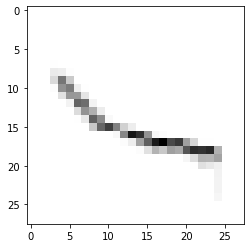

1


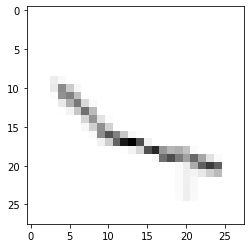

1


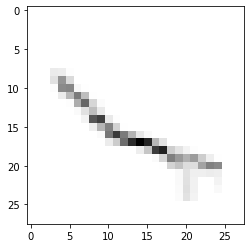

1


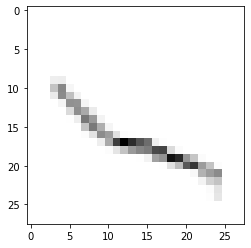

1


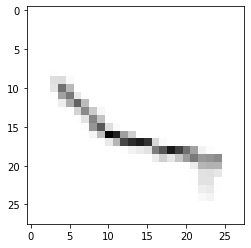

1


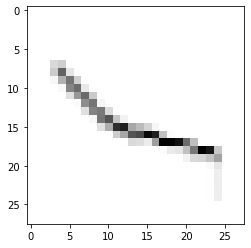

1


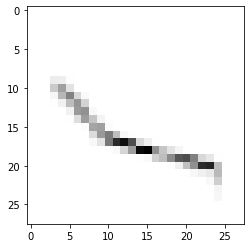

1


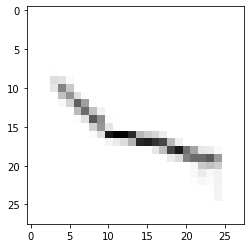

1


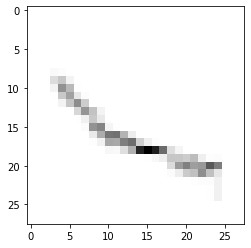

1


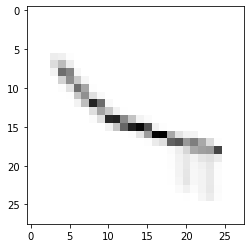

1


In [45]:
#display clusters
for i in range(0,200):
    if y_pred_kmeans[i]==1:
        plt.imshow(y[i].reshape(28, 28))
        plt.gray()
        plt.show()
        print(y_pred_kmeans[i])

In [28]:
for layer in vae.layers: print(layer.get_config(), layer.get_weights())

{'batch_input_shape': (None, 28, 28, 1), 'dtype': 'float32', 'sparse': False, 'name': 'encoder_input'} []
{'name': 'encoder', 'layers': [{'name': 'encoder_input', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 28, 28, 1), 'dtype': 'float32', 'sparse': False, 'name': 'encoder_input'}, 'inbound_nodes': []}, {'name': 'conv2d_1', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_1', 'trainable': True, 'dtype': 'float32', 'filters': 8, 'kernel_size': (3, 3), 'strides': (2, 2), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L1L2', 'config': {'l1': 0.0, 'l2': 0.009999999776482582}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bia

In [13]:
#test model on real swift curves
instances1 = []
directory1 = os.fsencode('final_light_curves_3')

# Load in the images
for filepath in os.listdir(directory1):
    path= 'final_light_curves_3/{0}'.format(os.fsdecode(filepath))
    instances1.append(path)

z = np.array([np.array(cv2.resize(cv2.imread(fname,0), dsize=(28,28), interpolation=cv2.INTER_CUBIC)) for fname in instances1 if fname not in ('final_light_curves_3/.ipynb_checkpoints')])


In [15]:
z = z.reshape(z.shape[0], 28, 28, 1)
z = z/255
z = z.reshape(z.shape[0], img_height, img_width, num_channels)

In [17]:
latent_space1 = encoder.predict(z)

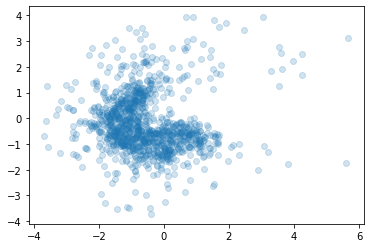

In [18]:
latent_space1 = np.array(latent_space1)
x123, y123 = zip(*latent_space1[0])
x123= np.array(x123)
y123 = np.array(y123)
plt.scatter(x123,y123, alpha=0.2)

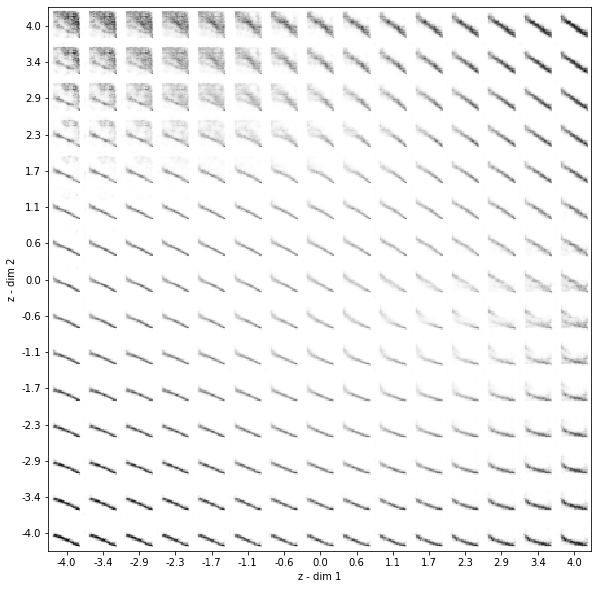

In [103]:
data1 = (z, z)
viz_decoded(encoder, decoder, data1)

In [51]:
z.shape

(1125, 28, 28, 1)